In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
from mpl_toolkits.basemap import Basemap
from matplotlib import colors

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cbook
from matplotlib.colors import LightSource

import sys
sys.path.append('/ocean/imachuca/Canyons/mackenzie_canyon/tools/')
import functions_plot

%matplotlib inline

/home/imachuca/anaconda3/envs/gsw/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
idealf = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/NEMO_files/idealized/ideal_bathy_for_agrif.nc')
ideal = idealf['Bathymetry'][:]
realf = nc.Dataset('/ocean/imachuca/Canyons/runs_mackenzie_canyon/prepare_real_bathy/real_bathy_for_agrif_fix.nc')
real = realf['Bathymetry'][:]
coordsf = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/coordinates/NEMO_files/coords_for_agrif.nc')
maskfi = nc.Dataset('/ocean/imachuca/Canyons/results_mackenzie/extended_domain/ideal_base/mesh_mask.nc')
maskfr = nc.Dataset('/ocean/imachuca/Canyons/results_mackenzie/extended_domain/real_base/mesh_mask.nc')

In [3]:
nav_lat = maskfr['nav_lat'][:]
nav_lon = maskfr['nav_lon'][:]

nav_lat.min(), nav_lat.max(), nav_lon.min(), nav_lon.max()

(68.40502, 72.69578, -150.76591, -132.92242)

In [4]:
e1i_mean = np.mean(maskfi['e1t'][0, :, :], axis=0)
e1r_mean = np.mean(maskfr['e1t'][0, :, :], axis=0)

dist_xi = np.cumsum(e1i_mean) 
dist_xr = np.cumsum(e1r_mean) 

e2i_mean = np.mean(maskfi['e2t'][0, :, :], axis=1)
e2r_mean = np.mean(maskfr['e2t'][0, :, :], axis=1)

dist_yi = np.cumsum(e2i_mean) 
dist_yr = np.cumsum(e2r_mean) 

In [5]:
maski = maskfi['tmask'][0, 0, :, :]
maskr = maskfr['tmask'][0, 0, :, :]

ideal_masked = np.ma.array(ideal, mask=1 - maski)
real_masked = np.ma.array(real, mask=1 - maskr)

In [6]:
# http://colorbrewer2.org/#type=sequential&scheme=GnBu&n=6
list_ocean = ['#f7fcf0','#ccebc5','#a8ddb5','#7bccc4','#4eb3d3','#2b8cbe','#0868ac','#084081']#'#e0f3db'(2nd)
cmap = LinearSegmentedColormap.from_list('mycmap', list_ocean, N=500, gamma=1)

# contour lines
levels_c = [40.5, 80, 220, 506, 1200]
levels_cf = np.arange(0, 1350, 50)
clocxr, clocxi = 90, 100
clocr=[(clocxr, 190), (clocxr, 220), (clocxr, 230), (clocxr, 250), (clocxr, 260)]
cloci=[(clocxi, 50), (clocxi+80, 140), (clocxi+40, 145), (clocxi, 150), (clocxi, 200)]

# AGRIF
inds_i = [90, 180, 10, 90]
inds_r = [130, 220, 10, 90]

# Figure - Methods 

L on plot:  98
W on plot:  62
L on plot:  98
W on plot:  62


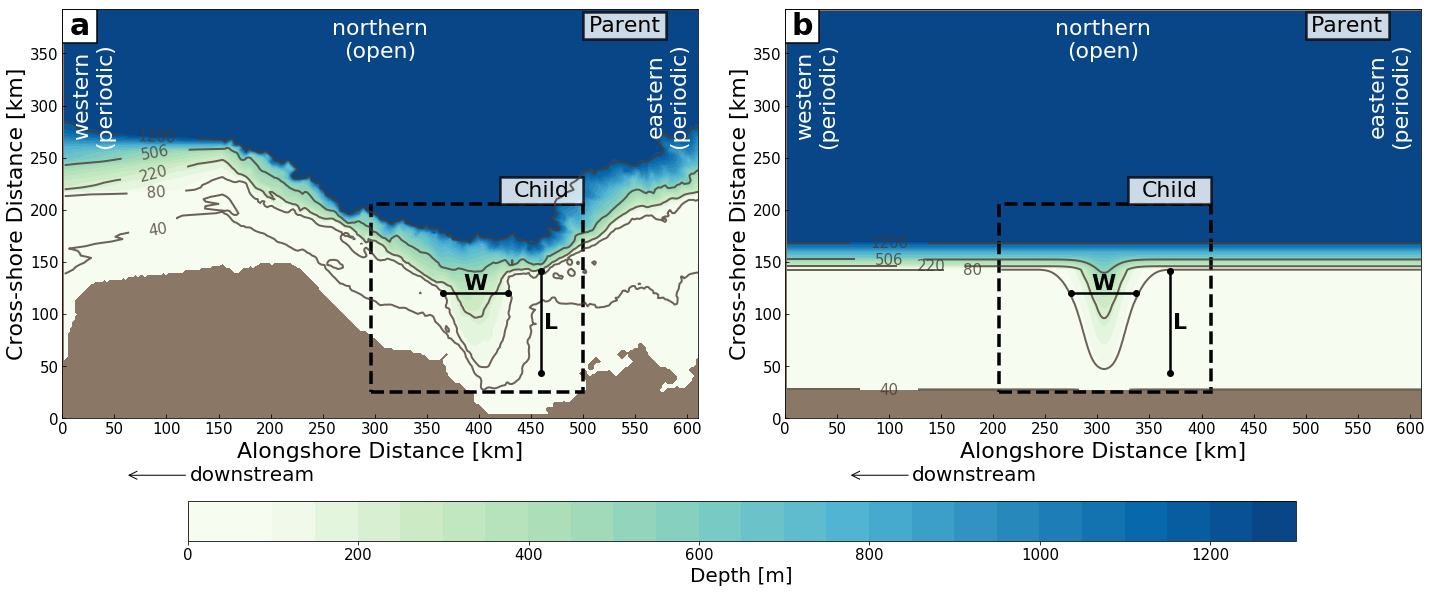

In [7]:
fig = plt.figure(figsize=(20, 9))
gs = gridspec.GridSpec(12, 10)
ax1 = plt.subplot(gs[:-1, :5])
ax2 = plt.subplot(gs[:-1, 5:])
cax = plt.subplot(gs[-1, :])

#fig, (ax1, ax2, cax) = plt.subplots(1,3,figsize=(18, 10), gridspec_kw={"width_ratios":[1,1, 0.08]})

axs = [ax1, ax2]
bathys = [real_masked, ideal_masked]
dist_xs = [dist_xr, dist_xi]
dist_ys = [dist_yr, dist_yi]
masks = [maskr, maski]
clocs = [clocr, cloci]
labs = ['a', 'b']
inds = [inds_r, inds_i]

for ax, bathy, dist_x, dist_y, mask, cloc, ind, lab in zip(axs, bathys, dist_xs, dist_ys, masks, clocs, inds, labs):
    dist_x_km, dist_y_km = dist_x/1000, dist_y/1000
    
    ax.patch.set_color('#8b7765')
    p = ax.contourf(dist_x_km, dist_y_km, bathy, cmap=cmap, vmin=100, vmax=1300, levels=levels_cf, zorder=1)
    c = ax.contour(dist_x_km, dist_y_km, bathy, levels=levels_c, colors='#483C32', linewidths=2, zorder=2, alpha=0.8)
    plt.clabel(c, inline=1, fontsize=15, fmt='%1.f', manual=cloc, inline_spacing=16)
    
    lw, ms, fs = 2.5, 12, 22
    if ax == ax1:
        x, y1, y2 = 460, 43, 141
        y, x1, x2 = 120, 366, 428
    elif ax == ax2:
        x, y1, y2 = 370, 43, 141
        y, x1, x2 = 120, 275, 337

    ax.plot([x, x], [y1, y2], lw=lw, c='k', marker='.', ms=ms)
    ax.plot([x1, x2], [y, y], lw=lw, c='k', marker='.', ms=ms)
    ax.text(0.5*(x2-x1)+x1, y+9, 'W', rotation='horizontal', fontsize=fs, color='k', va='center', ha='center', weight='bold')
    ax.text(x+9, 0.5*(y2-y1)+y1, 'L', rotation='horizontal', fontsize=fs, color='k', va='center', ha='center', weight='bold')
    print('L on plot: ', y2-y1)
    print('W on plot: ', x2-x1)
        
    # AGRIF 
    imin, imax, jmin, jmax = dist_x_km[ind[0]], dist_x_km[ind[1]], dist_y_km[ind[2]], dist_y_km[ind[3]]
    ax.add_patch(patches.Rectangle((imin, jmin),(imax-imin),(jmax-jmin), fill=None, ec='k', lw=3.5, ls='--')) 
    
    ax.set_xlim([0, dist_x_km[-1]])
    ax.set_ylim([0, dist_y_km[-1]])
    ax.xaxis.set_ticks(np.arange(0, 650, 50))
    ax.yaxis.set_ticks(np.arange(0, 400, 50))
    ax.tick_params(direction='in', length=4, color='k', labelsize=15)
    ax.set_aspect(aspect='equal')
    ax.set_xlabel('Alongshore Distance [km]', fontsize=fs, labelpad=5)
    ax.set_ylabel('Cross-shore Distance [km]', fontsize=fs, labelpad=3)
    
    # constants
    max_y = dist_y_km[-1]
    max_x = dist_x_km[-1]
    ind_y = 360
    ind_y_mid = ind_y + (max_y-ind_y)*0.5
    # plot label 
    ax.add_patch(patches.Rectangle((0, ind_y),(max_y-ind_y),(max_y-ind_y), fc='w', ec='k', lw=1.5, alpha=1))
    ax.annotate(lab, xy=((max_y-ind_y)*0.5, ind_y_mid), fontsize=30, weight='bold', va='center', ha='center')
    # boundaries
    wt = 'normal'
    ax.text(30, 310, 'western\n(periodic)', 
            rotation='vertical', fontsize=fs, color='w', weight=wt, va='center', ha='center')
    ax.text((max_x-30), 310, 'eastern\n(periodic)', 
            rotation='vertical', fontsize=fs, color='w', weight=wt, va='center', ha='center')
    ax.text((max_x*0.5), max_y-30, 'northern\n(open)', 
            rotation='horizontal', fontsize=fs, color='w', weight=wt, ha='center', va='center')
    # parent and child
    w, h = 80, 26
    ax.add_patch(patches.Rectangle((500, ind_y_mid-h*0.5),(w),(h), fc='w', ec='k', lw=2.5, alpha=0.8))
    ax.text(500+w*0.5, ind_y_mid, 'Parent', rotation='horizontal', fontsize=fs, color='k', ha='center', va='center')
    ax.add_patch(patches.Rectangle((imax-w, jmax),(w),(h), fc='w', ec='k', lw=2.5, alpha=0.8))
    ax.text(imax-w*0.5, jmax+h*0.5, 'Child', rotation='horizontal', fontsize=fs, color='k', ha='center', va='center')
    # direction of flow
    ax.annotate('downstream', xy=(0.1, -0.14), xycoords='axes fraction', xytext=(0.2, -0.14), 
                arrowprops=dict(arrowstyle="->", color='k'), ha='left', va='center', fontsize=20)
    #ax.grid(color='w')
    #ax.minorticks_on()
    #ax.grid(b=True, which='minor', color='gray', linestyle='-')
              

# colorbar
ip = InsetPosition(cax, [0.02, 0.05, 0.96, 0.95]) 
cax.set_axes_locator(ip)
cbar = fig.colorbar(p, cax=cax, ticks=np.arange(50, 1300, 150), orientation='horizontal')
cbar.ax.tick_params(labelsize=15)
cbar.set_label('Depth [m]', fontsize=20)
cbar.set_ticks(np.arange(0, 1500, 200))
    
# overall
gs.tight_layout(fig)
gs.update(wspace=1.5, hspace=0.005)
fig.savefig('./model_bathymetry.png', dpi=200, bbox_inches='tight', format='png')

# Figure - Map

https://matplotlib.org/basemap/users/stere.html

https://matplotlib.org/basemap/api/basemap_api.html

https://bitbucket.org/canyonsubc/mackenzie_canyon/src/default/tools/functions_plot.py

https://bitbucket.org/canyonsubc/analysis_mackenzie_canyon/src/default/notebooks/presentations/

https://www.kennethmoreland.com/color-maps/


In [7]:
#x_region, y_region, z_region = functions_plot.def_regionG(xl=-141.6, xr=-135.7, yb=69.1, yt=70.9)
#X, Y = np.meshgrid(x_region, y_region)

#ax2 = fig.add_subplot(1, 2, 2, projection='3d')
#ls = LightSource(270, 45)
#rgb = ls.shade(z_region, cmap=cmap, vert_exag=0.8, blend_mode='overlay', vmin=-3865, vmax=2370)
#surf = ax2.plot_surface(X, Y, z_region, rstride=1, cstride=1, facecolors=rgb, linewidth=0, antialiased=False, shade=False)
#ax2.set_xticks([])
#ax2.set_yticks([])
#ax2.grid(True)
#ax2.view_init(elev=40, azim=90)

In [8]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        result, is_scalar = self.process_value(value)
        (vmin,), _ = self.process_value(self.vmin)
        (vmax,), _ = self.process_value(self.vmax)
        resdat = np.asarray(result.data)
        result = np.ma.array(resdat, mask=result.mask, copy=False)
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        res = np.interp(result, x, y)
        result = np.ma.array(res, mask=result.mask, copy=False)
        if is_scalar:
            result = result[0]
        return result

In [9]:
# https://superdevresources.com/tools/color-shades#8b7765
list_ocean = ['#f7fcf0','#a8ddb5','#7bccc4','#4eb3d3','#2b8cbe','#0868ac','#084081'] #2,3 - ,'#e0f3db','#ccebc5'
#list_land = ['#4a3f36','#67594b','#857261','#9e8b7a', '#b4a598','#c9bfb5', '#dfd8d3']
#list_conc = list_land + list_ocean
#colour_list = list_conc[::-1]
colour_list = list_ocean
cmap = LinearSegmentedColormap.from_list('mycmap', colour_list, N=500, gamma=1)

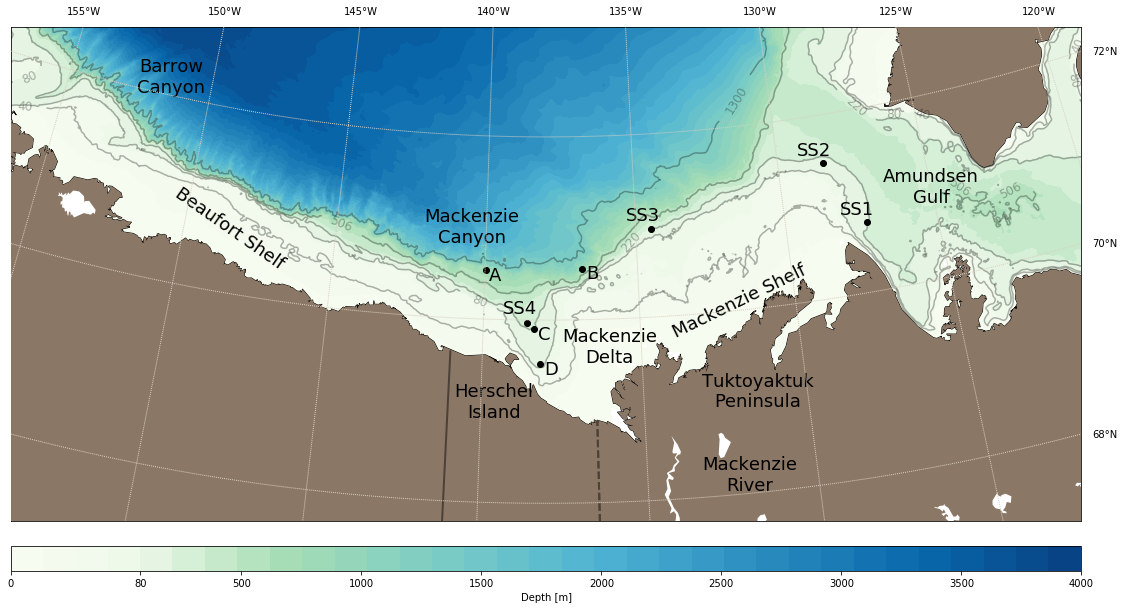

In [46]:
levels_p = np.concatenate((np.arange(0, 80, 20), np.linspace(80, 4000, 30)), axis=0)
levels_c = [40, 80, 220, 506, 1300]
ticks = np.concatenate((np.array([0, 80]), np.arange(500, 4500, 500)), axis=0)

fig, ax = plt.subplots(1,1,figsize=(20, 10))
#width=1600000, height=650000
m = Basemap(width=1300000, height=600000, resolution='i',projection='stere',
              lat_ts=70, lat_0=70.5, lon_0=-138., ax=ax)
m.drawcoastlines()
m.fillcontinents(color='#8b7765', alpha=1, zorder=3)
m.drawcountries(linewidth=2, linestyle='-', color='#4C4138', zorder=4)
m.drawstates(linewidth=2, linestyle='--', color='#4C4138', zorder=4)
m.drawparallels(np.arange(-80.,81.,2.0), labels=[False,True,False,False], color='#D9CFC1', zorder=4)#0.5
m.drawmeridians(np.arange(-180.,181.,5.0), labels=[False,False,True,False], color='#D9CFC1', zorder=4)#1.5

x_region, y_region, z_region = functions_plot.def_regionG(xl=-165, xr=-115, yb=66, yt=74)
X, Y = np.meshgrid(x_region, y_region) 
lon, lat = m(X, Y) 
z_positive = -1 * z_region

p = m.contourf(lon, lat, z_positive, cmap=cmap, levels=levels_p, zorder=1)
c = m.contour(lon, lat, z_positive, levels=levels_c, colors='k', alpha=0.3, zorder=2)
plt.clabel(c, inline=1, fontsize=12, fmt='%1.f', inline_spacing=16)
cbar = m.colorbar(p,location='bottom',pad="5%")
cbar.set_ticks(ticks)
cbar.set_ticklabels(ticks)
cbar.set_label('Depth [m]')

fs=18
a='center'

ax.annotate('Barrow\nCanyon', xy=(m(-151.5, 72.2)), fontsize=fs, va=a, ha=a)
ax.annotate('Mackenzie\nCanyon', xy=(m(-140.5, 71)), fontsize=fs, va=a, ha=a)
ax.annotate('Tuktoyaktuk\nPeninsula', xy=(m(-131.5, 69.1)), fontsize=fs, va=a, ha=a)
ax.annotate('Herschel\nIsland', xy=(m(-139.6, 69.1)), fontsize=fs, va=a, ha=a)
ax.annotate('Amundsen\nGulf', xy=(m(-125, 71)), fontsize=fs, va=a, ha=a)
ax.annotate('Mackenzie Shelf', xy=(m(-131.8, 70.1)), fontsize=fs, va=a, ha=a, rotation=26)
ax.annotate('Beaufort Shelf', xy=(m(-148.5, 70.7)), fontsize=fs, va=a, ha=a, rotation=325)
ax.annotate('Mackenzie\nDelta', xy=(m(-136, 69.7)), fontsize=fs, va=a, ha=a)
ax.annotate('Mackenzie\nRiver', xy=(m(-132, 68.2)), fontsize=fs, va=a, ha=a)

lons_mooring = [-139.983, -136.817, -138.383, -138.183, -127.315, -128.45, -134.485, -138.613]
lats_mooring = [70.533, 70.55, 69.9, 69.517, 70.767, 71.48, 70.962, 69.972]
name_mooring = ['A', 'B', 'C', 'D', 'SS1', 'SS2', 'SS3', 'SS4']
for xm, ym, name in zip(lons_mooring, lats_mooring, name_mooring):
    xmd, ymd = m(xm, ym)
    ax.scatter(xmd, ymd, c='k')
    if name == 'A' or name == 'B' or name == 'C' or name == 'D':
        xmd, ymd = m(xm+0.33, ym-0.05)
        ax.annotate(name, xy=(xmd, ymd), fontsize=fs, va='center', ha='center')
    else:
        xmd, ymd = m(xm-0.24, ym+0.15)
        ax.annotate(name, xy=(xmd, ymd), fontsize=fs, va='center', ha='center')


plt.show()

fig.savefig('./map_Beaufort.png', dpi=100, bbox_inches='tight')